# <a id='toc1_'></a>[Speech Emotion Recognition](#toc0_)

This notebook is all about experimenting different set of features for audio representation and different CNN-based architectures for building speech emotion recognition model. The notebook contains implementation for three new CNN-based architectures for speech emotion recognition. which are:
    - [DummyNet 1D](#toc1_9_2_)    
    - [RezoNet](#toc1_9_3_)      
    - [ExpoNet](#toc1_9_4_)       

**Table of contents**<a id='toc0_'></a>    
- [Speech Emotion Recognition](#toc1_)    
  - [Installing Required Libraries](#toc1_1_)    
  - [Importing Libraries](#toc1_2_)    
  - [Loading the dataset](#toc1_3_)    
  - [Audio Processing](#toc1_4_)    
  - [Parameters for Audio Features Extraction](#toc1_5_)    
  - [Reading, Plotting and Playing the Audio](#toc1_6_)    
  - [Feature Extraction](#toc1_7_)    
  - [Splitting the Dataset](#toc1_8_)    
  - [Building The models](#toc1_9_)    
    - [Dataset Class](#toc1_9_1_)    
    - [DummyNet 1D](#toc1_9_2_)    
      - [Model Architecture](#toc1_9_2_1_)    
      - [Using only Zero Crossing Rate](#toc1_9_2_2_)    
      - [Using only Energy](#toc1_9_2_3_)    
      - [Using both Zero Crossing Rate and Energy](#toc1_9_2_4_)    
      - [Using Mel Spectrogram](#toc1_9_2_5_)    
      - [Results](#toc1_9_2_6_)    
    - [RezoNet](#toc1_9_3_)    
      - [Model Architecture](#toc1_9_3_1_)    
      - [Training and Running the Model](#toc1_9_3_2_)    
    - [ExpoNet](#toc1_9_4_)    
      - [Model Architecture](#toc1_9_4_1_)    
      - [Running the Model](#toc1_9_4_2_)    
  - [Final Thoughts](#toc1_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Installing Required Libraries](#toc0_)

In [ ]:
#%pip install playsound
#%pip install tensorflow --user
#%pip install librosa
#%pip install torch --user
#%pip install optuna --user

## <a id='toc1_2_'></a>[Importing Libraries](#toc0_)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wave
import librosa
import os
from IPython.display import Audio
import IPython.display as ipd
from playsound import playsound
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import soundfile as sf
from sklearn.preprocessing import StandardScaler

stringLabels = ["SAD", "ANG", "NEU", "HAP", "FEA", "DIS"]
labelToIndex = {stringLabels[i]: i for i in range(len(stringLabels))}

## <a id='toc1_3_'></a>[Loading the dataset](#toc0_)

- We will load the CREMA dataset, then we will pad the audio files to have the same length as te longest one. Then we can rewrite the audio files to the disk which can be preprocessed by the `librosa` library later on.

In [3]:
files = np.array([])
labels = np.array([])
maxLen = 110361
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        if filename.endswith('.wav'):
            # Read the wav file
            files = np.append(files, os.path.join(dirname, filename))
            labels = np.append(labels, filename.split("_")[2])

# Now let's get the maximum length of the audio files
maxLen = 0
for file in files:
    audio, sr = librosa.load(file)
    if len(audio) > maxLen:
        maxLen = len(audio)

# Let's pad all the audio files with zeros so that they all have the same length
for i, file in enumerate(files):
    audio, sr = librosa.load(file)
    paddedAudio = np.pad(audio, (0, maxLen - len(audio)), mode='constant')
    sf.write(file, paddedAudio, sr)

# Check if all the files have the same length
for file in files:
    audio, sr = librosa.load(file)
    if len(audio) != maxLen:
        print("Error")

print("The maximum length of the audio files is: " + str(maxLen))

The maximum length of the audio files is: 110361


## <a id='toc1_4_'></a>[Audio Processing](#toc0_)

- We will process the audio files (wav files) mainly using `librosa` library. We will extract the following features:
    - Zero Crossing Rate
    - Energy
    - Mel Spectrogram
- We will also use data augmentation later on since that the size of the dataset is extremely small. We will use the following augmentation techniques:
    - Adding Noise
    - Time Shifting
    - Pitch Shifting
    - Time Stretching
    - Volume Scaling

In [3]:
def playAudio(path):
    playsound(path)

def getSamplingFrequency(path):
    fileData = wave.open(path, 'rb')
    # Extract Raw Audio from Wav File
    signal = fileData.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    # Get the frame rate
    frameRate = fileData.getframerate()
    return frameRate

def getAudioSignal(path):
    fileData = wave.open(path, 'rb')
    # Extract Raw Audio from Wav File
    signal = fileData.readframes(-1)
    signal = np.frombuffer(signal, dtype='int16')
    # Get the frame rate
    frameRate = fileData.getframerate()
    # Find the time of the audio file
    time = np.linspace(0, len(signal) / frameRate, num=len(signal))
    return signal, time


def calculateZeroCrossingRate(audioPath, frameSize, hopSize):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.zero_crossing_rate( y= audio, frame_length= frameSize, hop_length= hopSize)[0]) # We can make center=True to get more accurate results

def calculateEnergy(audioPath, frameSize, hopSize):
    """
    audioPath: The path of the audio file
    frameSize: The number of samples in each frame
    hopSize: The number of samples between successive frames
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    return np.array(librosa.feature.rms(y = audio, frame_length= frameSize, hop_length= hopSize)[0] ** 2) # We can make center=True to get more accurate results

def calculateMelSpectogram(audioPath, n_fft, hopSize, n_mels):
    """"
    n_fft: The number of points in the FFT, which determines the frequency resolution of the spectrogram
    hopSize: The number of samples between successive frames
    n_mels: The number of mel frequency bands to generate in the spectrogram or the number of filters in the filterbank
    """
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    mel_spec = librosa.feature.melspectrogram(y= audio, sr=sr, n_fft=n_fft, hop_length=hopSize, n_mels=n_mels)
    mel_spec_db  = librosa.power_to_db(mel_spec)
    # Normalize between 0 and 1
    if mel_spec_db.max() - mel_spec_db.min() != 0:
        mel_spec_db = (mel_spec_db - mel_spec_db.min()) / ((mel_spec_db.max() - mel_spec_db.min()) + 1e-6) # eps for numerical stability
    else:
        mel_spec_db = mel_spec_db - mel_spec_db.min()
    return mel_spec_db

def addNoise(y, sr):
    noise = np.random.randn(len(y))
    y_noise = y + 0.005 * noise
    return y_noise

def changeSpeed(y, sr):
    speed_change = np.random.uniform(low=0.9, high=1.1)
    return librosa.effects.time_stretch(y, rate = speed_change)

def timeShift(y, sr):
    shift_range = int(np.random.uniform(low=-5, high = 5) * 1000)
    return np.roll(y, shift_range)

def pitchShift(y, sr):
    pitch_change = int(np.random.randint(low=-3, high = 3))
    return librosa.effects.pitch_shift(y, sr = sr, n_steps=pitch_change)

def volumeScale(y, sr):
    volume_change = np.random.uniform(low=0.5, high = 1.5)
    return y * volume_change

def augmentData(data, label, savePath, noise, time_shift, change_speed, pitch_shift, volume_scale):
    augmentedData = []
    augmentedLabel = []
    flag = 0
    if not os.path.exists(savePath):
        os.makedirs(savePath)
        flag = 1
        
    for i in range(len(data)):
        fileName = data[i][8:23]
        
        if not flag:
            # Appending all of them to the augmentedData
            augmentedData.append(data[i])
            augmentedLabel.append(label[i])
            if noise:
                augmentedData.append(savePath+ "/" + str(fileName)+"_noised.wav")
                augmentedLabel.append(label[i])
            if change_speed:
                augmentedData.append(savePath+ "/" + str(fileName)+"_changeSpeed.wav")
                augmentedLabel.append(label[i])
            if time_shift:
                augmentedData.append(savePath+ "/" + str(fileName)+"_timeShift.wav")
                augmentedLabel.append(label[i])
            if pitch_shift:
                augmentedData.append(savePath+ "/" + str(fileName)+"_pitchShift.wav")
                augmentedLabel.append(label[i])
            if volume_scale:
                augmentedData.append(savePath+ "/" + str(fileName)+"_volumeScale.wav")
                augmentedLabel.append(label[i])
            continue
        
        augmentedData.append(data[i])
        augmentedLabel.append(label[i])

        audio, sr = librosa.load(data[i], sr=None)
        if noise:
            noisedAudio = addNoise(audio, sr)
            if( maxLen > len(noisedAudio) ):
                noisedAudio = np.pad(noisedAudio, (0, maxLen - len(noisedAudio)), 'constant')
            noisedAudio = noisedAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_noised.wav", noisedAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_noised.wav")
            augmentedLabel.append(label[i])
        if change_speed:
            changeSpeedAudio = changeSpeed(audio, sr)
            if( maxLen > len(changeSpeedAudio) ):
                changeSpeedAudio = np.pad(changeSpeedAudio, (0, maxLen - len(changeSpeedAudio)), 'constant')
            changeSpeedAudio = changeSpeedAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_changeSpeed.wav", changeSpeedAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_changeSpeed.wav")
            augmentedLabel.append(label[i])
        if time_shift:
            timeShiftAudio = timeShift(audio, sr)
            if( maxLen > len(timeShiftAudio) ):
                timeShiftAudio = np.pad(timeShiftAudio, (0, maxLen - len(timeShiftAudio)), 'constant')
            timeShiftAudio = timeShiftAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_timeShift.wav", timeShiftAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_timeShift.wav")
            augmentedLabel.append(label[i])
        if pitch_shift:
            pitchShiftAudio = pitchShift(audio, sr)
            if( maxLen > len(pitchShiftAudio) ):
                pitchShiftAudio = np.pad(pitchShiftAudio, (0, maxLen - len(pitchShiftAudio)), 'constant')
            pitchShiftAudio = pitchShiftAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_pitchShift.wav", pitchShiftAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_pitchShift.wav")
            augmentedLabel.append(label[i])
        if volume_scale:
            volumeScaleAudio = volumeScale(audio, sr)
            if( maxLen > len(volumeScaleAudio) ):
                volumeScaleAudio = np.pad(volumeScaleAudio, (0, maxLen - len(volumeScaleAudio)), 'constant')
            volumeScaleAudio = volumeScaleAudio[:maxLen]
            sf.write(savePath +  "/" + str(fileName)+"_volumeScale.wav", volumeScaleAudio, sr)
            augmentedData.append(savePath +  "/" + str(fileName)+"_volumeScale.wav")
            augmentedLabel.append(label[i])
    return augmentedData, augmentedLabel

def plotMelSpectogram(audioPath, n_fft, hopSize, n_mels):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    mel_spec = librosa.feature.melspectrogram(y= audio, sr=sr, n_fft=n_fft, hop_length=hopSize, n_mels=n_mels)
    mel_spec_db  = librosa.power_to_db(mel_spec)
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hopSize, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Mel spectrogram')
    plt.show()

def plotSpectrogram(audioPath, time):
    audio, sr = librosa.load(audioPath, sr=None)# we can make mono = True to convert it to 1 channel only
    plt.figure(figsize=(15, 5))
    plt.specgram(audio, Fs=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')
    plt.title('Spectrogram')
    plt.show()
    
def plotSignal(signal, time):
    plt.figure(figsize=(15, 5))
    plt.plot(time, signal)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Audio Signal')
    plt.show()

def plotHistogram(data, dataTitle):
    plt.figure(figsize=(15, 5))
    plt.hist(data, bins=15)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Histogram of the ' + dataTitle)
    plt.show()

## <a id='toc1_5_'></a>[Parameters for Audio Features Extraction](#toc0_)

- When selecting the window size and hop size for audio classification tasks using a convolutional neural network (CNN), it's important to consider several factors, including the length of the audio samples, the nature of the audio signal, and the computational resources available. Here are some general guidelines we will follow:
  - **Window Size**: The window size determines the amount of audio data that is processed at a time. A larger window size captures more information about the audio signal, but also requires more computational resources. For speech signals, a window size of around 20-30 ms (320-480 samples for 16 kHz audio) is often used, as it captures enough information about individual phonemes while still allowing for some temporal resolution.
  - **Hop Size**: The hop size determines the amount of overlap between adjacent windows. A smaller hop size provides more temporal resolution but requires more computational resources, while a larger hop size provides better computational efficiency but can miss short-term changes in the audio signal. A common hop size is half the window size, i.e. 10-15 ms (160-240 samples for 16 kHz audio).

- size (in samples) = duration (in seconds) x fs


In [4]:
N_MELS = 40 
N_FFT = 512 # 480
HOP_SIZE = 160
SR = getSamplingFrequency(files[0]) # Sampling rate is equal for all files (16kHz)

## <a id='toc1_6_'></a>[Reading, Plotting and Playing the Audio](#toc0_)

- Note that for the last part of the following signals the amplitude for the audio signal is zero since that we padded the audio files to have the same length as the longest one.

For the emotion: SAD


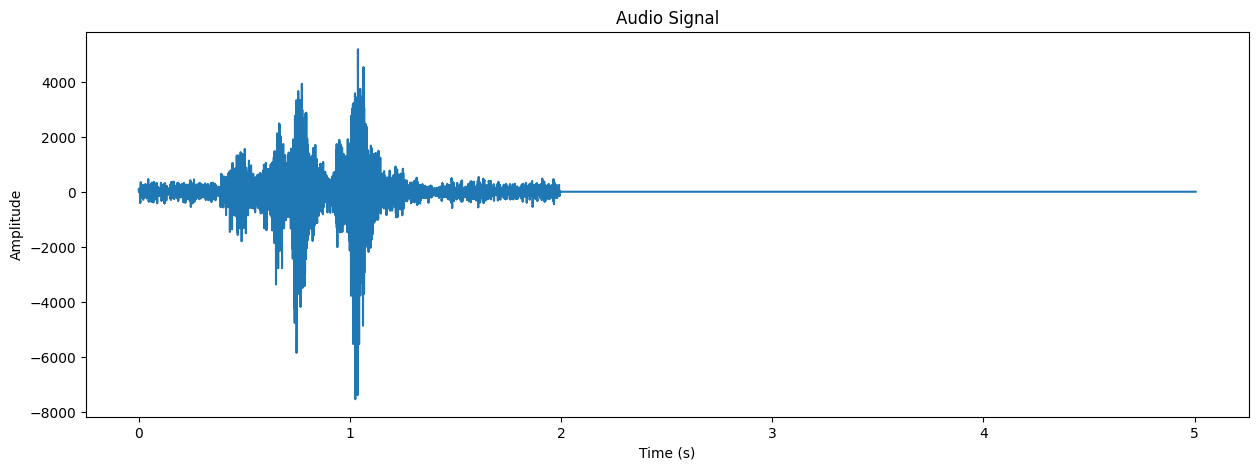

C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\axes\_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


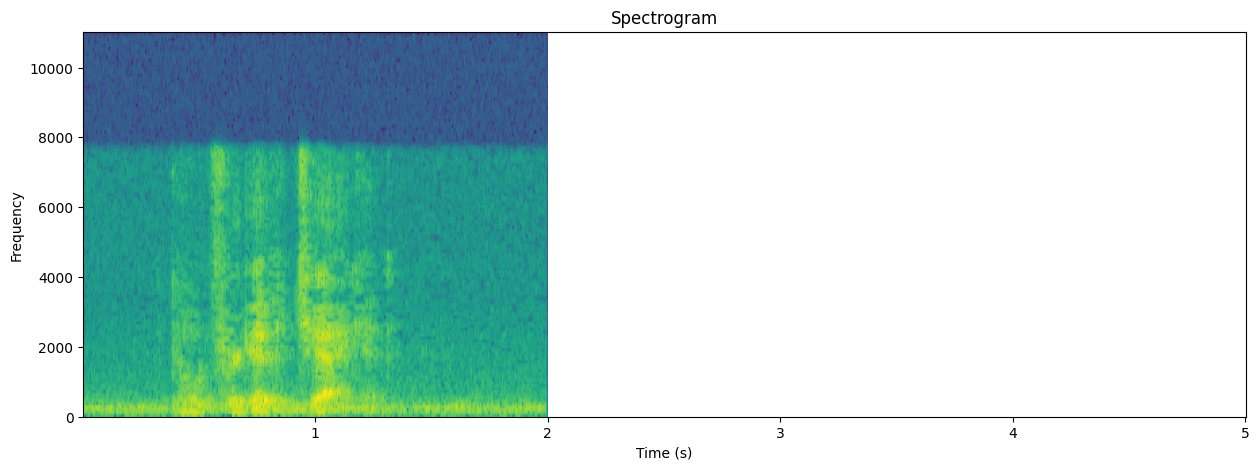

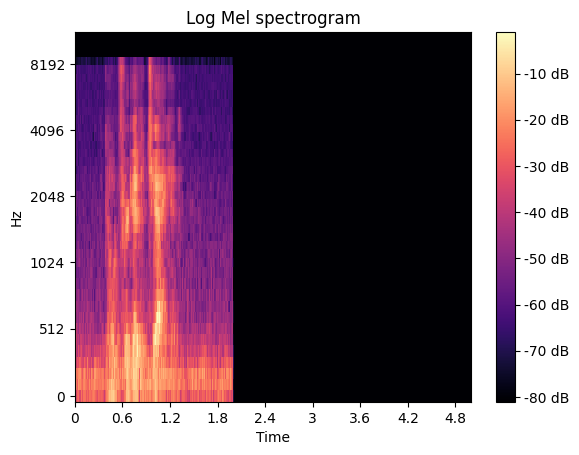

For the emotion: ANG


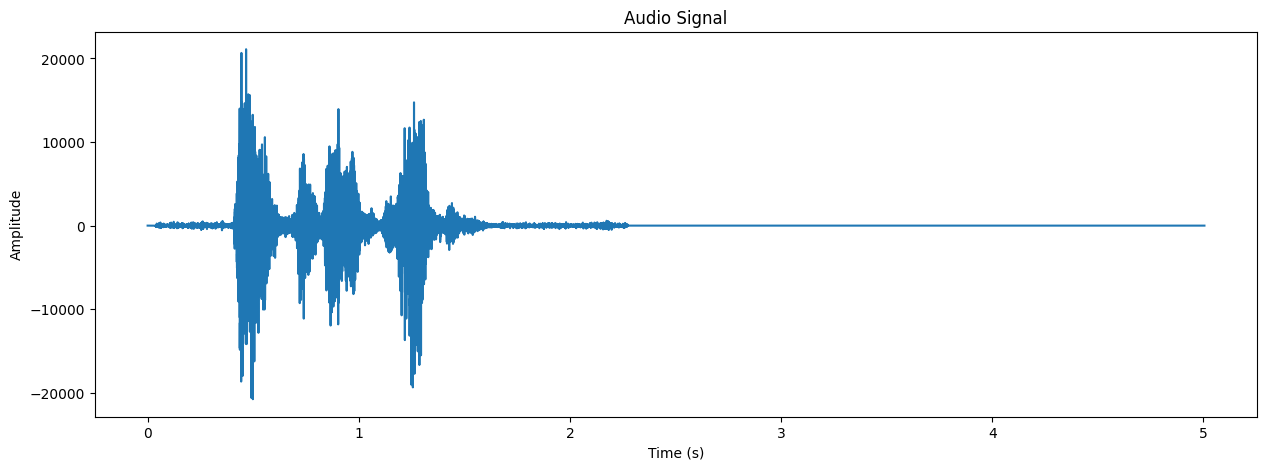

C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\axes\_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


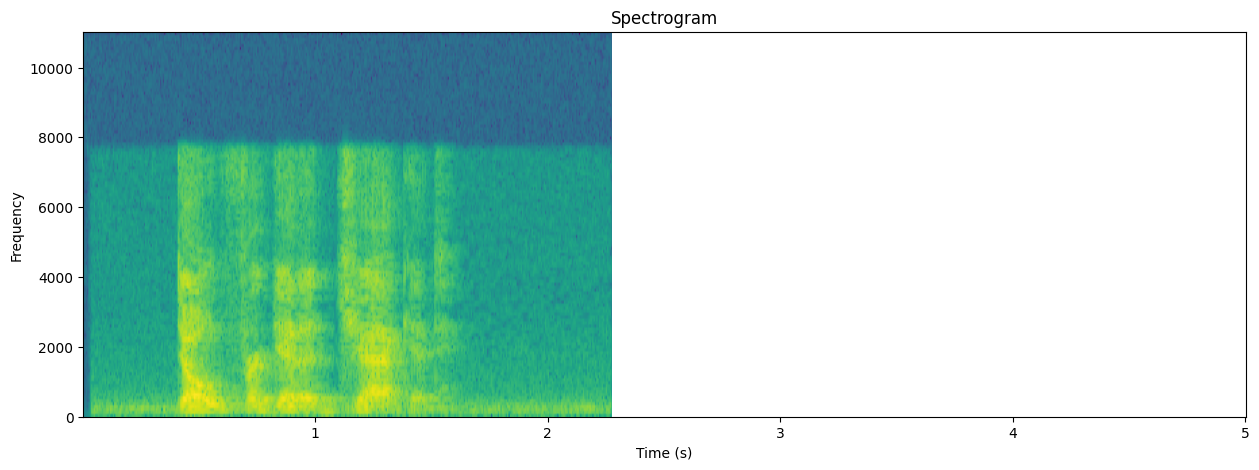

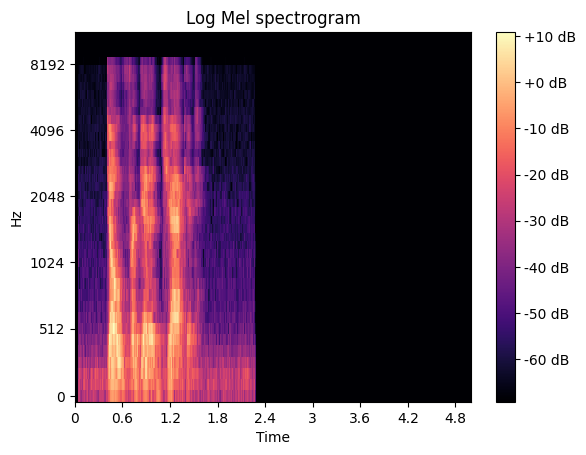

For the emotion: NEU


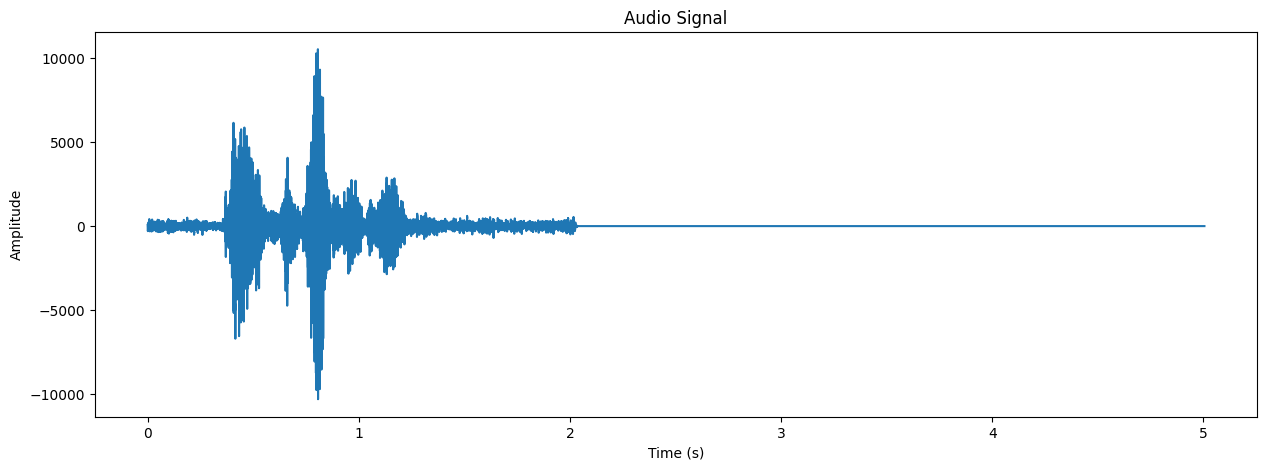

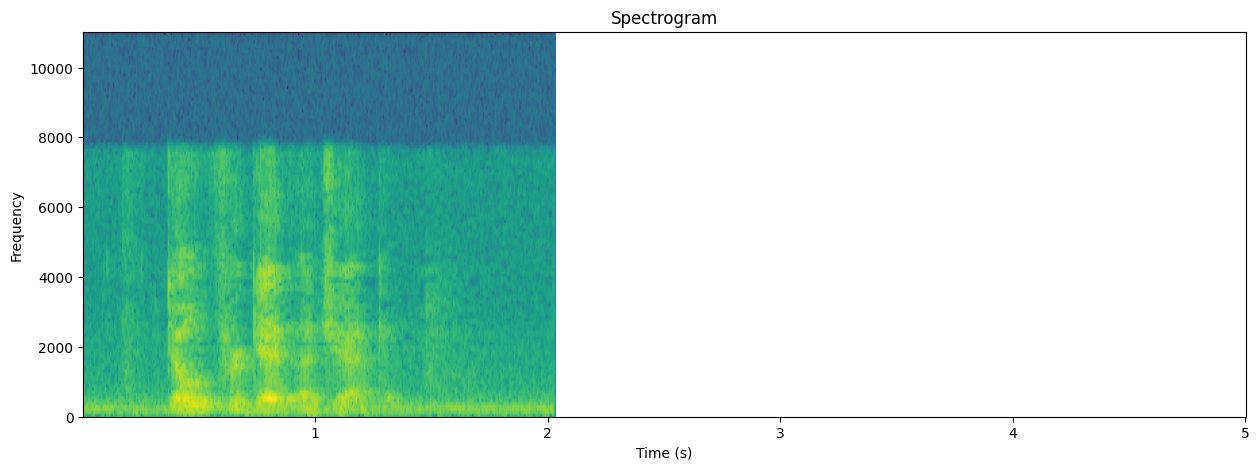

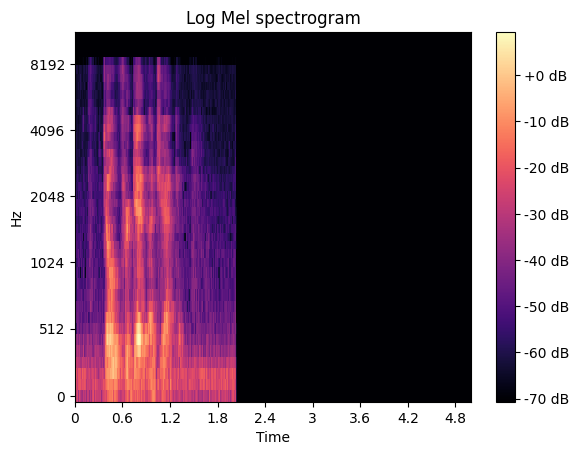

For the emotion: HAP


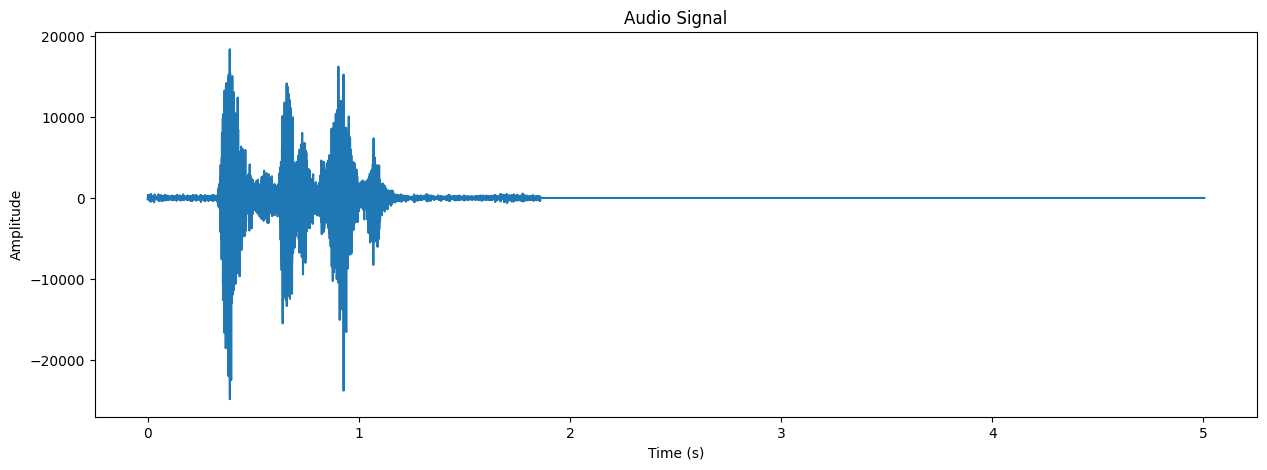

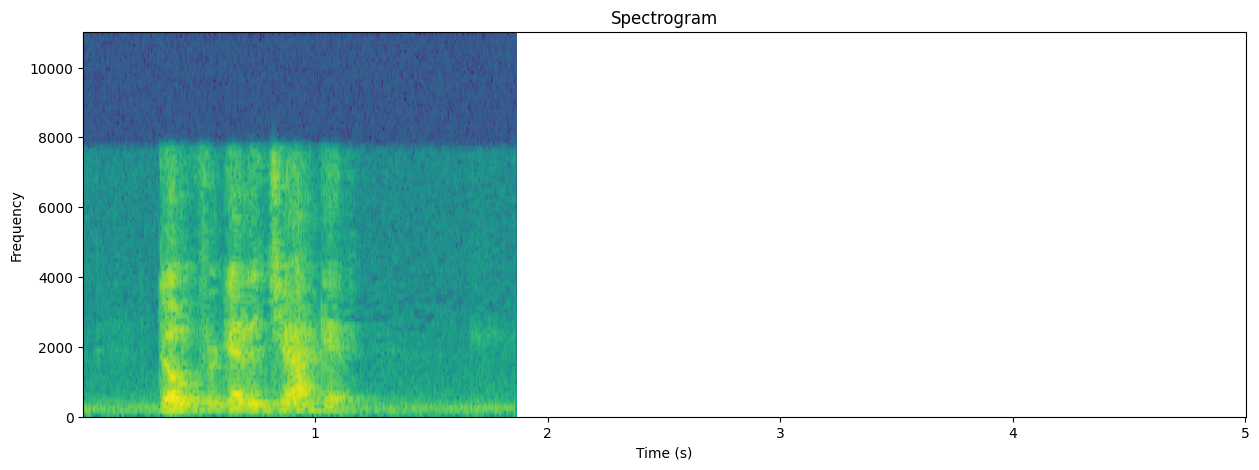

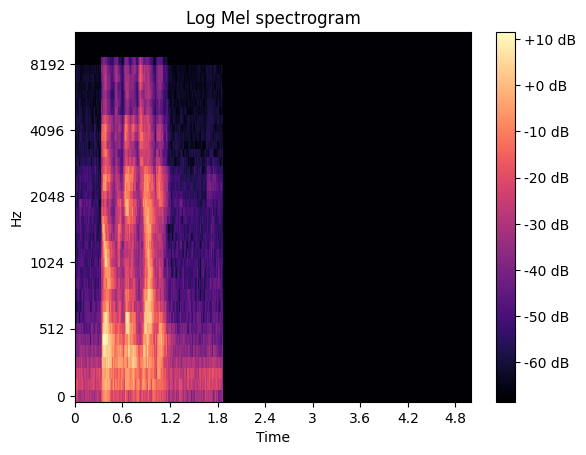

For the emotion: FEA


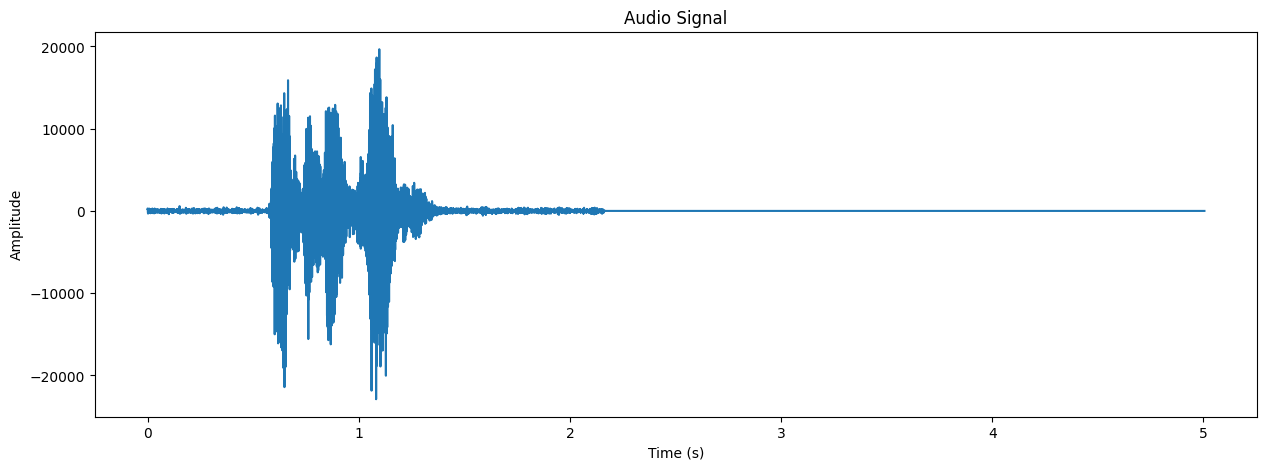

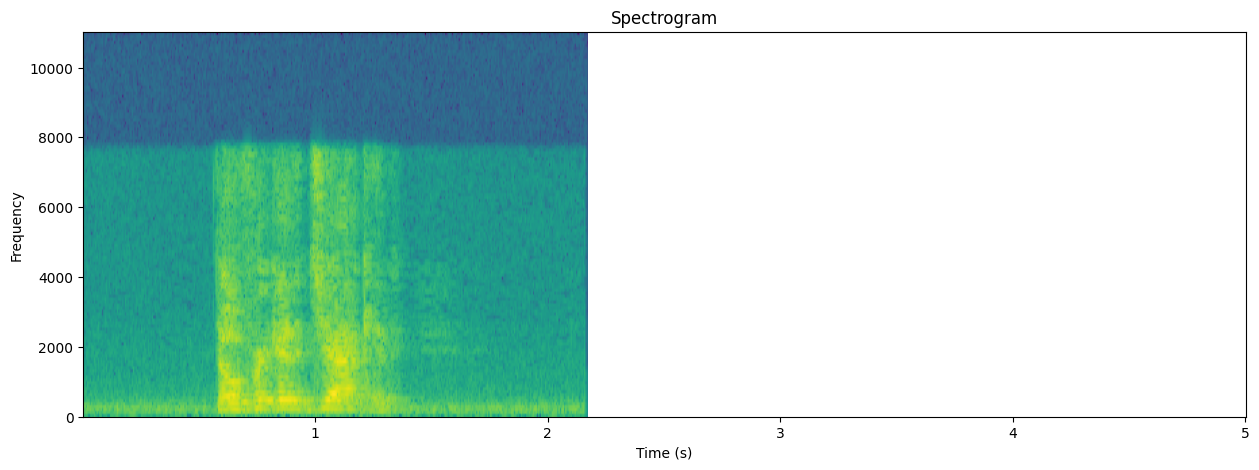

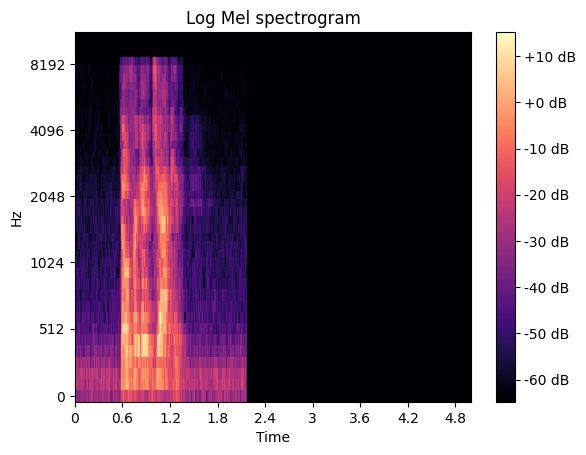

For the emotion: DIS


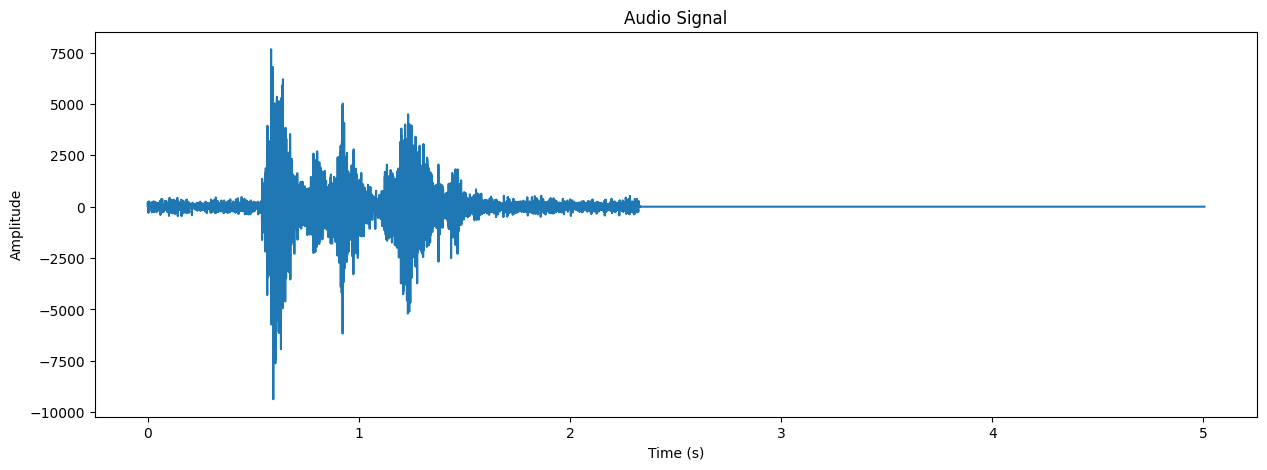

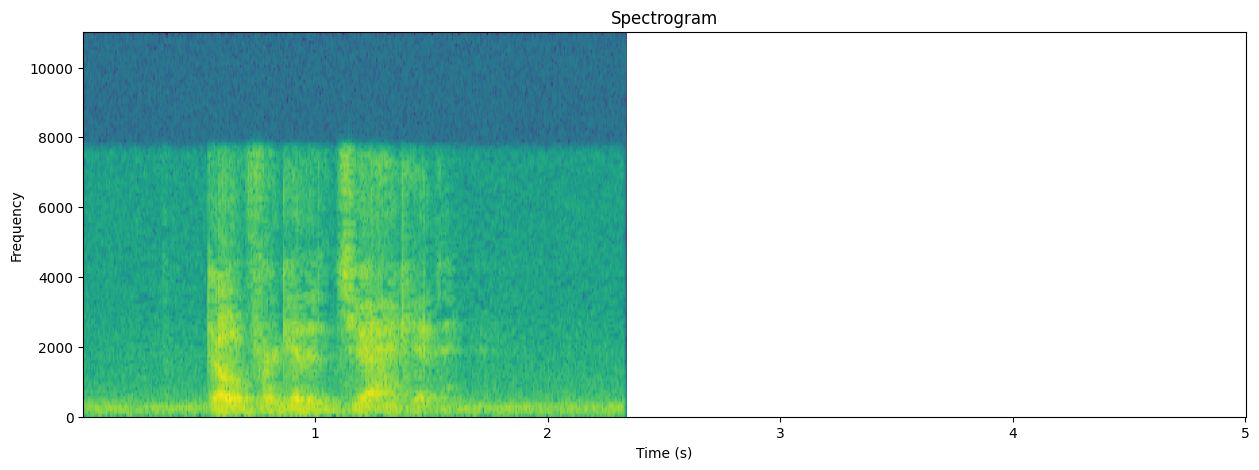

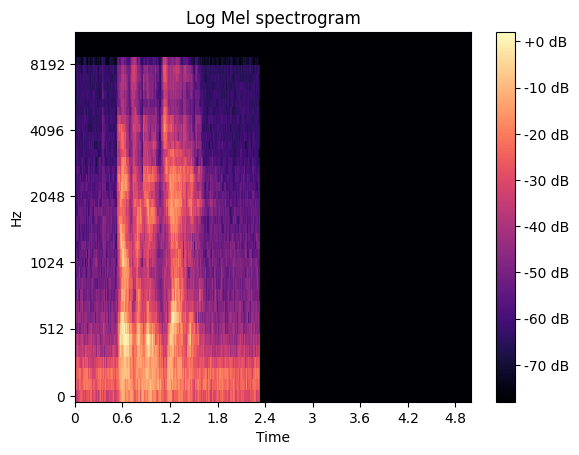

In [16]:
for i in range(len(stringLabels)):
    # Get the first file whose label is equal to the current label
    fileIndex = np.where(labels == stringLabels[i])[0][0]
    print("For the emotion: " + stringLabels[i])
    ipd.display(Audio(files[fileIndex]))
    audioSignal, audioTime = getAudioSignal(files[fileIndex])
    plotSignal(audioSignal, audioTime)
    plotSpectrogram(files[fileIndex], audioTime)
    plotMelSpectogram(files[fileIndex], N_FFT, HOP_SIZE, N_MELS)

## <a id='toc1_7_'></a>[Feature Extraction](#toc0_)

- We will create two feature spaces from the audio.
  - We can work on time domain, or we can work in frequency domain. There are multiple of features that can help improving the model:
    - Zero crossing rate: The rate of sign-changes of the signal during the duration of a particular frame.
    - Energy: The sum of squares of the signal values, normalized by the respective frame length.
  - Convert the audio waveform to mel spectrogram and use this as the feature space.

- We will later try combining all of them in one feature space in order to see if we can improve the model.

In [4]:
def extractFeatures(data, labels, n_fft, hopSize, n_mels):
    output = np.empty((len(data), 4), dtype=np.ndarray)
    
    for i, audioFile in enumerate(data):
        # Calculate the zero crossing rate
        zeroCrossingRate = calculateZeroCrossingRate(audioFile, n_fft, hopSize)
        # Calculate the energy
        energy = calculateEnergy(audioFile, n_fft, hopSize)
        # Calculate the Mel Spectrogram
        melSpectrogram = calculateMelSpectogram(audioFile, n_fft, hopSize, n_mels)
        # Append the features to the output array
        output[i][0] = zeroCrossingRate
        output[i][1] = energy
        output[i][2] = melSpectrogram
        output[i][3] = labels[i]
        output[i][0] = output[i][0].reshape(1, output[i][0].shape[0])
        output[i][1] = output[i][1].reshape(1, output[i][1].shape[0])
    return output

def getFeatures(files, labels, n_fft, hop_size, n_mels, noise = False, time_shift = False, change_speed = False, pitch_shift = False, volume_scale = False):
    savingDirectory = "processed/n_fft_" + str(n_fft) + "_hop_size_" + str(hop_size) + "_n_mels_" + str(n_mels)
    if noise:
        savingDirectory += "_noise"
    if time_shift:
        savingDirectory += "_timeShift"
    if change_speed:
        savingDirectory += "_changeSpeed"
    if pitch_shift:
        savingDirectory += "_pitchShift"
    if volume_scale:
        savingDirectory += "_volumeScale"
    if not os.path.exists(savingDirectory):
        
        x_train_val, x_test, y_train_val, y_test = train_test_split(files, labels, train_size=0.7, random_state=42, stratify=labels)
        x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, train_size=0.95, random_state=42, stratify=y_train_val)
        
        # Now let's augment the training data 
        augmentedData, augmentedLabel = augmentData(x_train, y_train, f"augmented/n_fft_{n_fft}_hop_size_{hop_size}_n_mels_{n_mels}", noise, time_shift, change_speed, pitch_shift, volume_scale)
        x_train = augmentedData
        y_train = augmentedLabel

        # Extract the features
        x_train = extractFeatures(x_train, y_train, n_fft, hop_size, n_mels)
        x_val = extractFeatures(x_val, y_val, n_fft, hop_size, n_mels)
        x_test = extractFeatures(x_test, y_test, n_fft, hop_size, n_mels)
        
        os.makedirs(savingDirectory)
        np.save(savingDirectory + "/x_train.npy", x_train)
        np.save(savingDirectory + "/x_val.npy", x_val)
        np.save(savingDirectory + "/x_test.npy", x_test)
        np.save(savingDirectory + "/y_train.npy", y_train)
        np.save(savingDirectory + "/y_val.npy", y_val)
        np.save(savingDirectory + "/y_test.npy", y_test)
    else:
        
        x_train = np.load(savingDirectory + "/x_train.npy", allow_pickle=True)
        x_val = np.load(savingDirectory + "/x_val.npy", allow_pickle=True)
        x_test = np.load(savingDirectory + "/x_test.npy", allow_pickle=True)
        y_train = np.load(savingDirectory + "/y_train.npy", allow_pickle=True)
        y_val = np.load(savingDirectory + "/y_val.npy", allow_pickle=True)
        y_test = np.load(savingDirectory + "/y_test.npy", allow_pickle=True)
    return x_train, x_val, x_test, y_train, y_val, y_test

## <a id='toc1_8_'></a>[Splitting the Dataset](#toc0_)

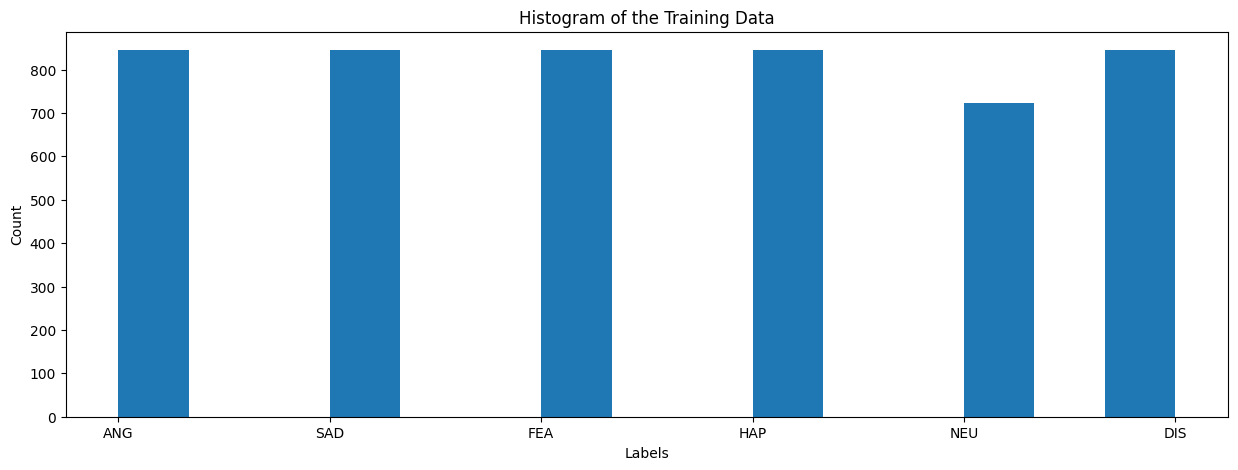

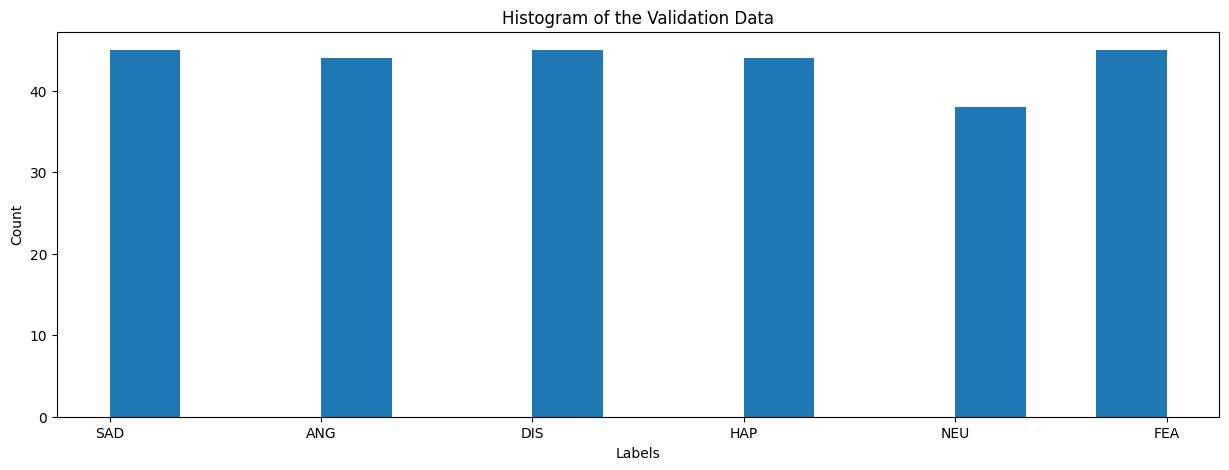

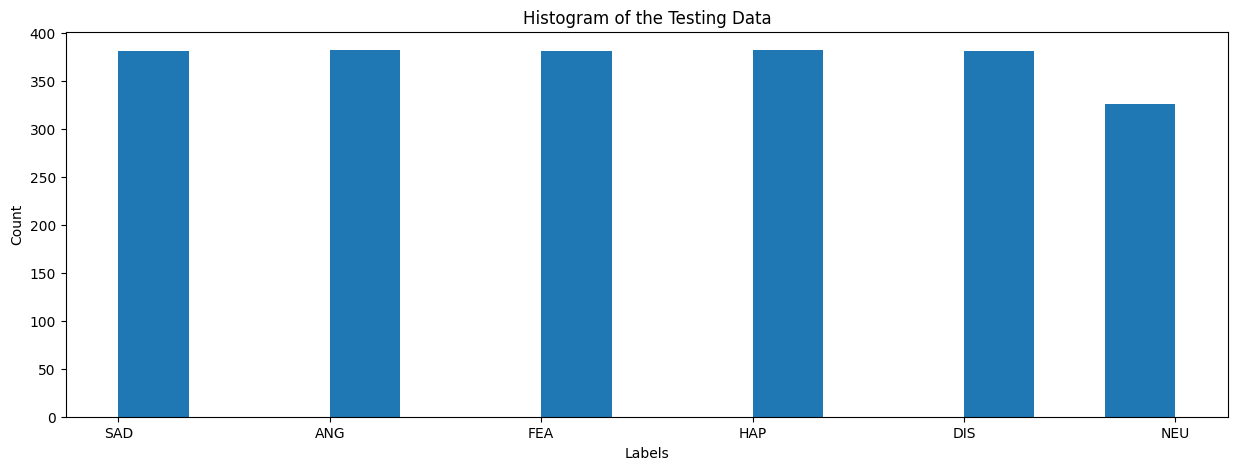

In [54]:
x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files, labels, N_FFT, HOP_SIZE, N_MELS)
# Plotting the histogram of the training data
plotHistogram(y_train, 'Training Data')
# Plotting the histogram of the validation data
plotHistogram(y_val, 'Validation Data')
# Plotting the histogram of the testing data
plotHistogram(y_test, 'Testing Data')

- We have the choice of either undersampling or oversampling the dataset. We will not be using either of them as they are not very effective in this case since the differences in number of samples is not big. However, ideally it is recommended to have equal number of each class. We will be using the entire dataset as it is.

## <a id='toc1_9_'></a>[Building The models](#toc0_)

- It is recommended to run the models on Cuda GPU.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch, gc
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The acceleration is on: ", device)

The acceleration is on:  cuda


### <a id='toc1_9_1_'></a>[Dataset Class](#toc0_)

- We will prepare our dataset which will be loaded later as a torch.tensor datatype using DataLoader class. Using DataLoader class will help us in loading the data in batches and shuffling the data.

In [8]:
class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.zcr = torch.tensor([data[i][0] for i in range(len(data))], dtype=torch.float32)
        self.energy = torch.tensor([data[i][1] for i in range(len(data))], dtype=torch.float32)
        self.melSpectogram = torch.tensor([data[i][2] for i in range(len(data))], dtype=torch.float32)
        
        indexLabels = [labelToIndex[labels[i]] for i in range(len(labels))]
        oneHotLabels = np.zeros((len(labels), len(stringLabels)))
        oneHotLabels[np.arange(len(labels)), indexLabels] = 1
        self.labels = torch.tensor(oneHotLabels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.zcr)
    
    def __getitem__(self, idx):
        return self.zcr[idx], self.energy[idx], self.melSpectogram[idx], self.labels[idx]

### <a id='toc1_9_2_'></a>[DummyNet 1D](#toc0_)

- Let's start with the most basic CNN model which is DummyNet 1D. We will use the following features:
  - Zero Crossing Rate
  - Energy
  - Zero Crossing Rate and Energy combined
  - Flattened Mel Spectrogram

#### <a id='toc1_9_2_1_'></a>[Model Architecture](#toc0_)

In [42]:
class DummyNet1d(nn.Module):
    
    training_losses = []
    validation_losses = []
    hyperparameters = None
    input_shape = None
    current_epoch = None

    def __init__(self, input_shape, useZCR = False, useEnergy = False, useMelSpectogram = False, hyperparameters = None):
        super(DummyNet1d, self).__init__()
        self.hyperparameters = hyperparameters
        self.input_shape = input_shape
        self.current_epoch = 0
        self.useZCR = useZCR
        self.useEnergy = useEnergy
        self.useMelSpectogram = useMelSpectogram

        self.conv1 = nn.Conv1d(1, 512, kernel_size=5, stride=1)
        self.updateShape(5, 1, 0)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.updateShape(5, 2, 0)
        self.conv2 = nn.Conv1d(512, 512, kernel_size=5, stride=1)
        self.updateShape(5, 1, 0)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.updateShape(5, 2, 0)
        self.conv3 = nn.Conv1d(512, 128, kernel_size=5, stride=1)
        self.updateShape(5, 1, 0)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.updateShape(5, 2, 0)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.input_shape * 128, 256)
        self.fc2 = nn.Linear(256, 6)

    def forward(self, x):
        
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
    
    def trainEpochs(self, criterion, optimizer, train_loader, val_loader):
        num_epochs = self.hyperparameters['epochs']
        for epoch in range(self.current_epoch, num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.train()
            for i, data in enumerate(train_loader):
                zcr, energy, melSpectogram, labels = data
                zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)

                inputs = self.checkInputs(zcr, energy, melSpectogram)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * melSpectogram.size(0)
                
            self.eval()
            for i, data in enumerate(val_loader):
                zcr, energy, melSpectogram, labels = data
                zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
                inputs = self.checkInputs(zcr, energy, melSpectogram)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * melSpectogram.size(0)
                
            train_loss = train_loss / len(train_loader.dataset)
            val_loss = val_loss / len(val_loader.dataset)
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)
            print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(epoch+1, train_loss, val_loss))

    def checkInputs(self, zcr, energy, melSpectogram):
        if(self.useZCR and self.useEnergy):
            inputs = torch.cat((zcr, energy), dim=2)
        elif(self.useZCR):
            inputs = zcr
        elif(self.useEnergy):
            inputs = energy
        elif(self.useMelSpectogram):
            # flatten the last two shapes of the melSpectogram
            inputs = melSpectogram.view(self.hyperparameters["batch_size"], 1, -1)
        return inputs

    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)
    
    def test(self, test_loader):
        self.eval()
        accuracy = 0
        for i, data in enumerate(test_loader):
            zcr, energy, melSpectogram, labels = data
            zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
            inputs = self.checkInputs(zcr, energy, melSpectogram)
            output = self.predict(inputs)
            label = torch.argmax(labels, dim=1)
            accuracy += torch.sum(output == label)
        accuracy = accuracy / len(test_loader.dataset)
        return accuracy

    def analyze(self, test_loader):
        self.eval()
        output = []
        label = []
        for i, data in enumerate(test_loader):
            zcr, energy, melSpectogram, labels = data
            zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
            inputs = self.checkInputs(zcr, energy, melSpectogram)
            output.append(self.predict(inputs))
            label.append(torch.argmax(labels, dim=1))
        output = torch.cat(output)
        label = torch.cat(label)
        self.plotHistory()
        print(classification_report(label.cpu(), output.cpu(), target_names=stringLabels))
        ConfusionMatrixDisplay(confusion_matrix(label.cpu(), output.cpu()), display_labels=stringLabels).plot()
        plt.show()

    def getSoftmaxOutput(self, data_loader):
        self.eval()
        outputs = []
        for i, data in enumerate(data_loader):
            zcr, energy, melSpectogram, labels = data
            zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
            inputs = self.checkInputs(zcr, energy, melSpectogram)
            output = self.forward(inputs)
            outputs.append(output)
        return outputs
    
    def plotHistory(self):
        plt.plot(self.training_losses, label='Training loss', color='blue')
        plt.plot(self.validation_losses, label='Validation loss', color='yellow')
        plt.legend(frameon=False)
        plt.show()
    
    def saveModel(self):
        # path is models/DummyNet1d_hyperparameters.pt
        path = "models/DummyNet1d_"
        for key, value in self.hyperparameters.items():
            path += key + "_" + str(value) + "_"
        path += ".pt"
        torch.save(self.state_dict(), path)
    
    def updateShape(self, kernel_size, stride, padding):
        self.input_shape = (self.input_shape + 2*padding - kernel_size) // stride + 1

#### <a id='toc1_9_2_2_'></a>[Using only Zero Crossing Rate](#toc0_)

In [ ]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
USE_NOISE = True
USE_TIME_SHIFT = True
USE_CHANGE_SPEED = True
USE_PITCH_SHIFT = True
USE_VOLUME_SCALE = True

x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = USE_NOISE, time_shift = USE_TIME_SHIFT, change_speed = USE_CHANGE_SPEED, pitch_shift = USE_PITCH_SHIFT, volume_scale = USE_VOLUME_SCALE)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Epoch: 1 	Training Loss: 1.780321 	Validation Loss: 1.709646
Epoch: 2 	Training Loss: 1.714303 	Validation Loss: 1.675033
Epoch: 3 	Training Loss: 1.686967 	Validation Loss: 1.682007
Epoch: 4 	Training Loss: 1.673376 	Validation Loss: 1.681523
Epoch: 5 	Training Loss: 1.669993 	Validation Loss: 1.679050
Epoch: 6 	Training Loss: 1.662860 	Validation Loss: 1.647067
Epoch: 7 	Training Loss: 1.658112 	Validation Loss: 1.651798
Epoch: 8 	Training Loss: 1.655219 	Validation Loss: 1.655693
Epoch: 9 	Training Loss: 1.652042 	Validation Loss: 1.644121
Epoch: 10 	Training Loss: 1.652500 	Validation Loss: 1.651746
Epoch: 11 	Training Loss: 1.649035 	Validation Loss: 1.656940
Epoch: 12 	Training Loss: 1.647365 	Validation Loss: 1.645125
Epoch: 13 	Training Loss: 1.644136 	Validation Loss: 1.644513
Epoch: 14 	Training Loss: 1.642302 	Validation Loss: 1.648715
Epoch: 15 	Training Loss: 1.630631 	Validation Loss: 1.641764
Epoch: 16 	Training Loss: 1.628132 	Validation Loss: 1.642435
Epoch: 17 	Traini

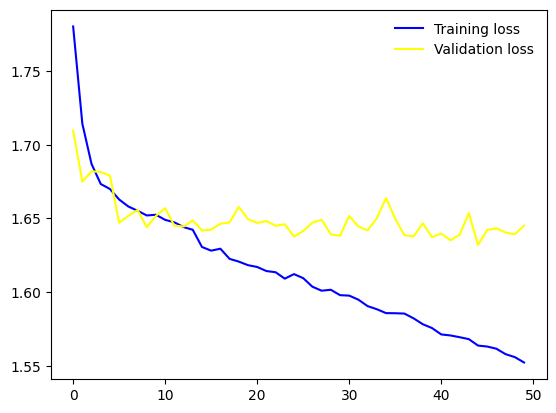

              precision    recall  f1-score   support

         SAD       0.45      0.53      0.49       381
         ANG       0.55      0.59      0.57       382
         NEU       0.34      0.44      0.39       326
         HAP       0.33      0.43      0.37       382
         FEA       0.33      0.11      0.17       381
         DIS       0.41      0.34      0.37       381

    accuracy                           0.41      2233
   macro avg       0.40      0.41      0.39      2233
weighted avg       0.40      0.41      0.39      2233



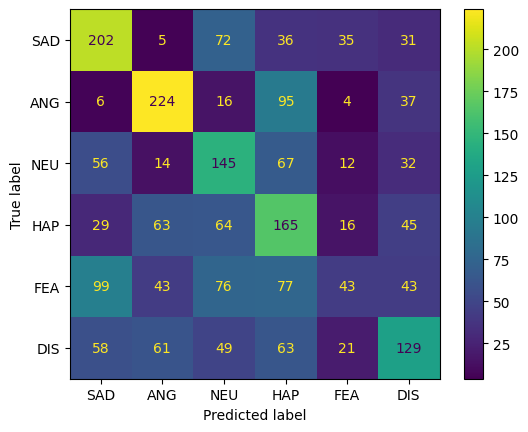

In [28]:
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.0001
USE_ZCR = True
USE_ENERGY = False
USE_MEL_SPECTOGRAM = False
hyperparameters = {"batch_size": BATCH_SIZE, "epochs": EPOCHS, "learning_rate": LEARNING_RATE, "useZCR": USE_ZCR, "useEnergy": USE_ENERGY, "useMelSpectogram": USE_MEL_SPECTOGRAM, "n_fft": N_FFT, "hop_size": HOP_SIZE, "n_mels": N_MELS, "useNoise": USE_NOISE, "useTimeShift": USE_TIME_SHIFT, "useChangeSpeed": USE_CHANGE_SPEED, "usePitchShift": USE_PITCH_SHIFT, "useVolumeScale": USE_VOLUME_SCALE}

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][0].shape[1], useZCR = USE_ZCR, useEnergy = USE_ENERGY, useMelSpectogram = USE_MEL_SPECTOGRAM, hyperparameters = hyperparameters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader)
model.analyze(test_dataloader)
model.saveModel()

#### <a id='toc1_9_2_3_'></a>[Using only Energy](#toc0_)

In [32]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
USE_NOISE = True
USE_TIME_SHIFT = True
USE_CHANGE_SPEED = True
USE_PITCH_SHIFT = True
USE_VOLUME_SCALE = True

x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = USE_NOISE, time_shift = USE_TIME_SHIFT, change_speed = USE_CHANGE_SPEED, pitch_shift = USE_PITCH_SHIFT, volume_scale = USE_VOLUME_SCALE)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Epoch: 1 	Training Loss: 1.773003 	Validation Loss: 1.734685
Epoch: 2 	Training Loss: 1.697819 	Validation Loss: 1.691546
Epoch: 3 	Training Loss: 1.672110 	Validation Loss: 1.676176
Epoch: 4 	Training Loss: 1.654548 	Validation Loss: 1.663122
Epoch: 5 	Training Loss: 1.644031 	Validation Loss: 1.640142
Epoch: 6 	Training Loss: 1.638133 	Validation Loss: 1.632336
Epoch: 7 	Training Loss: 1.634447 	Validation Loss: 1.646534
Epoch: 8 	Training Loss: 1.631737 	Validation Loss: 1.630310
Epoch: 9 	Training Loss: 1.630265 	Validation Loss: 1.650744
Epoch: 10 	Training Loss: 1.627372 	Validation Loss: 1.644134
Epoch: 11 	Training Loss: 1.625732 	Validation Loss: 1.645496
Epoch: 12 	Training Loss: 1.623219 	Validation Loss: 1.650456
Epoch: 13 	Training Loss: 1.630090 	Validation Loss: 1.652353
Epoch: 14 	Training Loss: 1.619911 	Validation Loss: 1.650154
Epoch: 15 	Training Loss: 1.622340 	Validation Loss: 1.662808
Epoch: 16 	Training Loss: 1.620958 	Validation Loss: 1.659982
Epoch: 17 	Traini

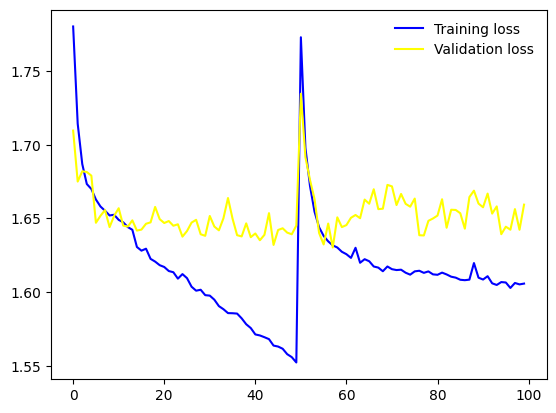

              precision    recall  f1-score   support

         SAD       0.56      0.47      0.51       381
         ANG       0.55      0.72      0.62       382
         NEU       0.36      0.51      0.42       326
         HAP       0.32      0.38      0.34       382
         FEA       0.31      0.15      0.20       381
         DIS       0.35      0.28      0.31       381

    accuracy                           0.42      2233
   macro avg       0.41      0.42      0.40      2233
weighted avg       0.41      0.42      0.40      2233



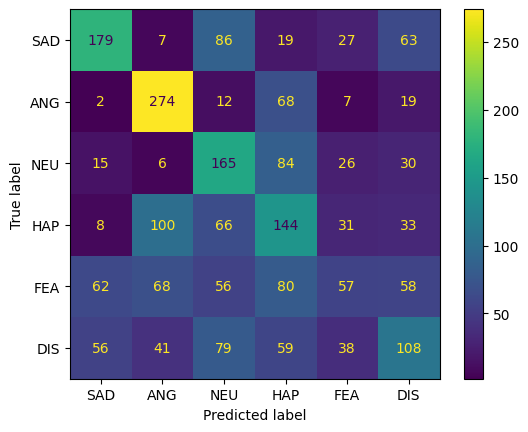

In [33]:
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.0001
USE_ZCR = False
USE_ENERGY = True
USE_MEL_SPECTOGRAM = False
hyperparameters = {"batch_size": BATCH_SIZE, "epochs": EPOCHS, "learning_rate": LEARNING_RATE, "useZCR": USE_ZCR, "useEnergy": USE_ENERGY, "useMelSpectogram": USE_MEL_SPECTOGRAM, "n_fft": N_FFT, "hop_size": HOP_SIZE, "n_mels": N_MELS, "useNoise": USE_NOISE, "useTimeShift": USE_TIME_SHIFT, "useChangeSpeed": USE_CHANGE_SPEED, "usePitchShift": USE_PITCH_SHIFT, "useVolumeScale": USE_VOLUME_SCALE}

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][1].shape[1], useZCR = USE_ZCR, useEnergy = USE_ENERGY, useMelSpectogram = USE_MEL_SPECTOGRAM, hyperparameters = hyperparameters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader)
model.analyze(test_dataloader)
model.saveModel()

#### <a id='toc1_9_2_4_'></a>[Using both Zero Crossing Rate and Energy](#toc0_)

In [ ]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
USE_NOISE = True
USE_TIME_SHIFT = True
USE_CHANGE_SPEED = True
USE_PITCH_SHIFT = True
USE_VOLUME_SCALE = True

x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = USE_NOISE, time_shift = USE_TIME_SHIFT, change_speed = USE_CHANGE_SPEED, pitch_shift = USE_PITCH_SHIFT, volume_scale = USE_VOLUME_SCALE)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Epoch: 1 	Training Loss: 1.740968 	Validation Loss: 1.682625
Epoch: 2 	Training Loss: 1.658346 	Validation Loss: 1.646479
Epoch: 3 	Training Loss: 1.644282 	Validation Loss: 1.646536
Epoch: 4 	Training Loss: 1.632315 	Validation Loss: 1.628102
Epoch: 5 	Training Loss: 1.626567 	Validation Loss: 1.622081
Epoch: 6 	Training Loss: 1.627550 	Validation Loss: 1.637309
Epoch: 7 	Training Loss: 1.622123 	Validation Loss: 1.632853
Epoch: 8 	Training Loss: 1.617336 	Validation Loss: 1.620668
Epoch: 9 	Training Loss: 1.615092 	Validation Loss: 1.613304
Epoch: 10 	Training Loss: 1.612072 	Validation Loss: 1.637373
Epoch: 11 	Training Loss: 1.610592 	Validation Loss: 1.614849
Epoch: 12 	Training Loss: 1.608380 	Validation Loss: 1.606062
Epoch: 13 	Training Loss: 1.604491 	Validation Loss: 1.604572
Epoch: 14 	Training Loss: 1.602022 	Validation Loss: 1.607825
Epoch: 15 	Training Loss: 1.599705 	Validation Loss: 1.603591
Epoch: 16 	Training Loss: 1.598456 	Validation Loss: 1.607610
Epoch: 17 	Traini

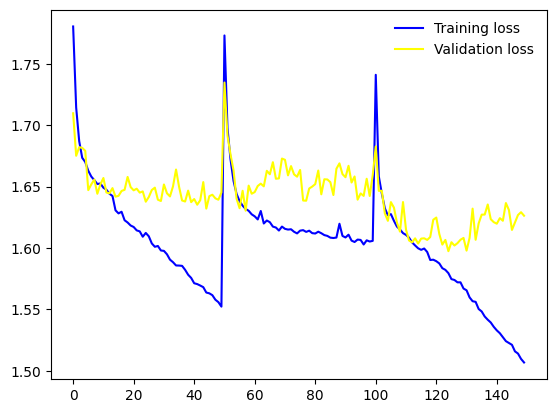

C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

              precision    recall  f1-score   support

         SAD       0.40      0.65      0.50       381
         ANG       0.61      0.66      0.63       382
         NEU       0.00      0.00      0.00       326
         HAP       0.33      0.52      0.40       382
         FEA       0.28      0.20      0.23       381
         DIS       0.42      0.37      0.39       381

    accuracy                           0.41      2233
   macro avg       0.34      0.40      0.36      2233
weighted avg       0.35      0.41      0.37      2233



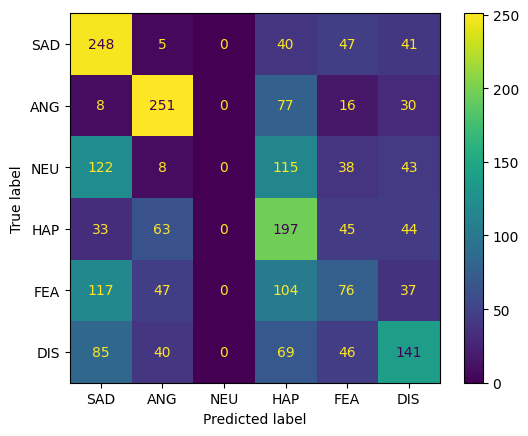

In [39]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.0001
USE_ZCR = True
USE_ENERGY = True
USE_MEL_SPECTOGRAM = False
hyperparameters = {"batch_size": BATCH_SIZE, "epochs": EPOCHS, "learning_rate": LEARNING_RATE, "useZCR": USE_ZCR, "useEnergy": USE_ENERGY, "useMelSpectogram": USE_MEL_SPECTOGRAM, "n_fft": N_FFT, "hop_size": HOP_SIZE, "n_mels": N_MELS, "useNoise": USE_NOISE, "useTimeShift": USE_TIME_SHIFT, "useChangeSpeed": USE_CHANGE_SPEED, "usePitchShift": USE_PITCH_SHIFT, "useVolumeScale": USE_VOLUME_SCALE}

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][1].shape[1] + x_train[0][0].shape[1], useZCR = USE_ZCR, useEnergy = USE_ENERGY, useMelSpectogram = USE_MEL_SPECTOGRAM, hyperparameters = hyperparameters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader)
model.analyze(test_dataloader)
model.saveModel()

#### <a id='toc1_9_2_5_'></a>[Using Mel Spectrogram](#toc0_)

In [65]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
USE_NOISE = True
USE_TIME_SHIFT = True
USE_CHANGE_SPEED = True
USE_PITCH_SHIFT = True
USE_VOLUME_SCALE = True

x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = USE_NOISE, time_shift = USE_TIME_SHIFT, change_speed = USE_CHANGE_SPEED, pitch_shift = USE_PITCH_SHIFT, volume_scale = USE_VOLUME_SCALE)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Epoch: 1 	Training Loss: 1.604651 	Validation Loss: 1.610332
Epoch: 2 	Training Loss: 1.528970 	Validation Loss: 1.569263
Epoch: 3 	Training Loss: 1.485197 	Validation Loss: 1.565122
Epoch: 4 	Training Loss: 1.449249 	Validation Loss: 1.576491
Epoch: 5 	Training Loss: 1.418231 	Validation Loss: 1.552909


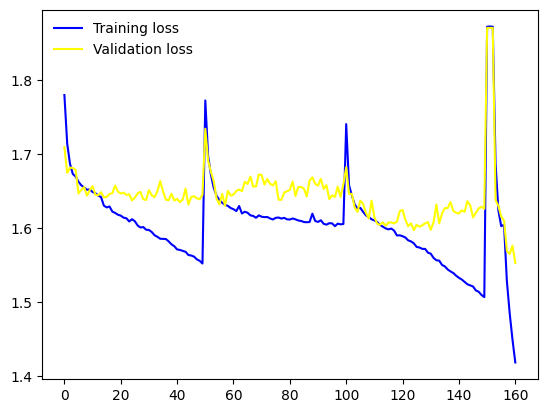

              precision    recall  f1-score   support

         SAD       0.58      0.58      0.58       381
         ANG       0.62      0.72      0.67       382
         NEU       0.57      0.44      0.50       326
         HAP       0.45      0.47      0.46       382
         FEA       0.44      0.35      0.39       381
         DIS       0.40      0.48      0.44       381

    accuracy                           0.51      2233
   macro avg       0.51      0.51      0.51      2233
weighted avg       0.51      0.51      0.51      2233



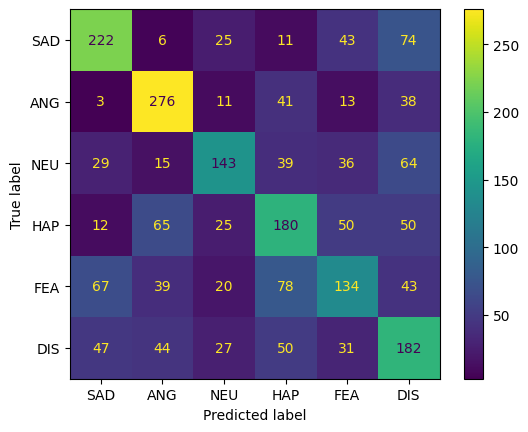

In [67]:
BATCH_SIZE = 1
EPOCHS = 5
LEARNING_RATE = 0.00001
USE_ZCR = False
USE_ENERGY = False
USE_MEL_SPECTOGRAM = True
hyperparameters = {"batch_size": BATCH_SIZE, "epochs": EPOCHS, "learning_rate": LEARNING_RATE, "useZCR": USE_ZCR, "useEnergy": USE_ENERGY, "useMelSpectogram": USE_MEL_SPECTOGRAM, "n_fft": N_FFT, "hop_size": HOP_SIZE, "n_mels": N_MELS, "useNoise": USE_NOISE, "useTimeShift": USE_TIME_SHIFT, "useChangeSpeed": USE_CHANGE_SPEED, "usePitchShift": USE_PITCH_SHIFT, "useVolumeScale": USE_VOLUME_SCALE}

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = DummyNet1d(x_train[0][2].shape[0]* x_train[0][2].shape[1], useZCR = USE_ZCR, useEnergy = USE_ENERGY, useMelSpectogram = USE_MEL_SPECTOGRAM, hyperparameters = hyperparameters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.trainEpochs(criterion = criterion, optimizer = optimizer, train_loader = train_dataloader, val_loader = val_dataloader)
model.analyze(test_dataloader)
model.saveModel()

#### <a id='toc1_9_2_6_'></a>[Results](#toc0_)

- From the previous results, it is clear that the model is so naive and simple that it can't learn anything meaningful from the data. We can tell that from the rate of training loss since that it is decreasing so slow. 
- The Zero Crossing Rate is not the best feature to use in this case since it is not very informative. The Energy feature is better than the Zero Crossing Rate, but it is still not enough. In addition to this, combining both of them together gives nearly the same results as using only the Energy feature. However, the F1 measure prefers the Energy feature alone over the combination of both of them or the Zero Crossing Rate alone.
- The Mel Spectrogram is the best feature to use in this case since it is the most informative one. It is better than using both Zero Crossing Rate and Energy together.
- **Note:** the graph for training loss and validation loss for each model is appended to the previous one so that is can be clear to see the difference between them.

### <a id='toc1_9_3_'></a>[RezoNet](#toc0_)

- RezoNet is a Deep-Net A Lightweight CNN-Based Speech Emotion Recognition Model. It consists of a group of different rectangular shaped kernels in convolutional layer and pooling layer. The model is inspired from the research [Deep-Net: A Lightweight CNN-Based Speech Emotion Recognition System Using Deep Frequency Features](https://www.mdpi.com/1424-8220/20/18/5212). The model is trained on 2D Mel Spectrogram features extracted from the audio files.

#### <a id='toc1_9_3_1_'></a>[Model Architecture](#toc0_)

In [8]:
class RezoNet(nn.Module):
    
    input_shape = None
    training_losses = []
    validation_losses = []
    current_epoch = 0
    hyperparameters = None

    def __init__(self, input_shape, hyperparameters):
        super(RezoNet, self).__init__()
        self.flatten = nn.Flatten()
        self.input_shape = input_shape
        self.hyperparameters = hyperparameters
        self.current_epoch = 0

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (1,9))
        self.updateCurrentShape((1,9), (1,1),(0,0))

        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (1,5))
        self.updateCurrentShape((1,5), (1,1),(0,0))

        self.conv3 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (1,3))
        self.updateCurrentShape((1,3), (1,1),(0,0))

        self.pool1 = nn.MaxPool2d(kernel_size = (1,3), stride = (1,1))
        self.updateCurrentShape((1,3), (1,1),(0,0))

        self.bn1 = nn.BatchNorm2d(10)

    
        self.conv4 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (1,3))
        self.updateCurrentShape((1,3), (1,1),(0,0))

        self.conv5 = nn.Conv2d(in_channels = 20, out_channels = 20, kernel_size = (1,3))
        self.updateCurrentShape((1,3), (1,1),(0,0))

        self.pool2 = nn.MaxPool2d(kernel_size = (1,2))
        input_shape[0] = input_shape[0] // 1
        input_shape[1] = input_shape[1] // 2

        self.bn2 = nn.BatchNorm2d(20)
        

        self.conv6 = nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = (1,13))
        self.updateCurrentShape((1,13), (1,1),(0,0))

        self.conv7 = nn.Conv2d(in_channels = 40, out_channels = 40, kernel_size = (1,1))
        self.updateCurrentShape((1,1), (1,1),(0,0))

        self.pool3 = nn.MaxPool2d(kernel_size = (1,2))
        input_shape[0] = input_shape[0] // 1
        input_shape[1] = input_shape[1] // 2

        self.bn3 = nn.BatchNorm2d(40)

        self.conv8 = nn.Conv2d(in_channels = 40, out_channels = 80, kernel_size = (1,1))
        flattened = input_shape[0] * input_shape[1] * 80
        self.fc1 = nn.Linear(flattened, 256)
        self.fc2 = nn.Linear(256, 64)
        self.softmax = nn.Linear(64, 6)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = self.bn1(x)

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(x)
        x = self.bn2(x)

        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.pool3(x)
        x = self.bn3(x)

        x = F.relu(self.conv8(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(self.softmax(x), dim = 1)
        return x
    
    def trainEpochs(self, criterion, optimizer, train_loader, val_loader, lr_decay = False, lr_decay_epoch = 5, lr_decay_factor = 0.1, save_each = None):
        num_epochs = self.hyperparameters['epochs']
        for epoch in range(self.current_epoch, num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.train()
            for i, data in enumerate(train_loader):
                _, _, melSpectogram, labels = data
                melSpectogram, labels =  melSpectogram.to(device), labels.to(device)
                # unsqueeze the melSpectogram to add a channel dimension
                melSpectogram = melSpectogram.unsqueeze(1)
                optimizer.zero_grad()
                outputs = self(melSpectogram)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * melSpectogram.size(0)

            self.eval()
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    _, _, melSpectogram, labels = data
                    melSpectogram, labels = melSpectogram.to(device), labels.to(device)
                    melSpectogram = melSpectogram.unsqueeze(1)
                    outputs = self(melSpectogram)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * melSpectogram.size(0)
            train_loss = train_loss / len(train_loader.dataset)
            val_loss = val_loss / len(val_loader.dataset)
            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)

            print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(self.current_epoch+1, train_loss, val_loss))
            if lr_decay and (epoch+1) % lr_decay_epoch == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_decay_factor
            if save_each and (epoch+1) % save_each == 0:
                self.saveModel()
            self.current_epoch += 1

    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)
    
    def test(self, test_loader):
        self.eval()
        accuracy = 0
        for i, data in enumerate(test_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            output = self.predict(melSpectogram)
            label = torch.argmax(labels, dim=1)
            accuracy += torch.sum(output == label)
        accuracy = accuracy / len(test_loader.dataset)
        return accuracy
    
    def analyze(self, test_loader):
        self.eval()
        output = []
        label = []
        for i, data in enumerate(test_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            output.append(self.predict(melSpectogram))
            label.append(torch.argmax(labels, dim=1))
        output = torch.cat(output)
        label = torch.cat(label)
        self.plotHistory()
        print(classification_report(label.cpu(), output.cpu(), target_names=stringLabels))
        ConfusionMatrixDisplay(confusion_matrix(label.cpu(), output.cpu()), display_labels=stringLabels).plot()
        plt.show()

    

    def updateCurrentShape(self, kernel_size, stride, padding):
        self.input_shape[0] = (self.input_shape[0] + 2*padding[0] - kernel_size[0]) // stride[0] + 1
        self.input_shape[1] = (self.input_shape[1] + 2*padding[1] - kernel_size[1])// stride[1] + 1
    
    def saveModel(self):
        path = "models/RezoNet"
        for key, value in self.hyperparameters.items():
            path += key + "_" + str(value) + "_"
        path += "current_epoch_" + str(self.current_epoch +1)
        path += ".pt"
        torch.save(self.state_dict(), path)

    def plotHistory(self):
        plt.plot(self.training_losses, label='Training loss', color='blue')
        plt.plot(self.validation_losses, label='Validation loss', color='yellow')
        plt.legend(frameon=False)
        # plot starting from 0 on y axis
        plt.ylim(bottom=0)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def getSoftmaxOutput(self, data_loader):
        self.eval()
        outputs = []
        for i, data in enumerate(data_loader):
            _, _, melSpectogram, labels = data
            melSpectogram, labels = melSpectogram.to(device), labels.to(device)
            output = self.forward(melSpectogram)
            outputs.append(output)
        return outputs

#### <a id='toc1_9_3_2_'></a>[Training and Running the Model](#toc0_)

In [9]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
noise = True
time_shift = True
change_speed = True
pitch_shift = True
volume_scale = True


x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = noise, time_shift = time_shift, change_speed = change_speed, pitch_shift = pitch_shift, volume_scale = volume_scale)
print("Extracted Features for the Data Successfully!")
print("Number of Training Examples: ", len(x_train))
print("Number of Validation Examples: ", len(x_val))
print("Number of Testing Examples: ", len(x_test))

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Extracted Features for the Data Successfully!
Number of Training Examples:  29688
Number of Validation Examples:  261
Number of Testing Examples:  2233


C:\Users\Yousef\AppData\Local\Temp\ipykernel_7420\645635343.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  self.zcr = torch.tensor([data[i][0] for i in range(len(data))], dtype=torch.float32)


In [33]:
BATCH_SIZE = 16
EPOCHS = 86
LEARNING_RATE = 0.00001
LR_DECAY = True
LR_DECAY_EPOCH = 50
LR_DECAY_FACTOR = 0.1
WEIGHT_DECAY = 1e-2
SAVE_EACH = 5

hyperparameters = {"batch_size": BATCH_SIZE, "epochs": EPOCHS, "learning_rate": LEARNING_RATE, "lr_decay": LR_DECAY, "lr_decay_epoch": LR_DECAY_EPOCH, "lr_decay_factor": LR_DECAY_FACTOR, "weight_decay": WEIGHT_DECAY}

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = RezoNet([x_train[0][2].shape[0], x_train[0][2].shape[1]], hyperparameters = hyperparameters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)
model.trainEpochs(criterion, optimizer, train_dataloader, val_dataloader, lr_decay=LR_DECAY, lr_decay_epoch=LR_DECAY_EPOCH, lr_decay_factor=LR_DECAY_FACTOR, save_each = SAVE_EACH)

Epoch: 1 	Training Loss: 1.600838 	Validation Loss: 1.590646
Epoch: 2 	Training Loss: 1.504550 	Validation Loss: 1.578519
Epoch: 3 	Training Loss: 1.450535 	Validation Loss: 1.562933
Epoch: 4 	Training Loss: 1.411718 	Validation Loss: 1.547424
Epoch: 5 	Training Loss: 1.377075 	Validation Loss: 1.551694
Epoch: 6 	Training Loss: 1.344460 	Validation Loss: 1.550317
Epoch: 7 	Training Loss: 1.319048 	Validation Loss: 1.556812
Epoch: 8 	Training Loss: 1.296052 	Validation Loss: 1.551534
Epoch: 9 	Training Loss: 1.273169 	Validation Loss: 1.559819
Epoch: 10 	Training Loss: 1.257291 	Validation Loss: 1.571553
Epoch: 11 	Training Loss: 1.239669 	Validation Loss: 1.563662
Epoch: 12 	Training Loss: 1.224360 	Validation Loss: 1.560473
Epoch: 13 	Training Loss: 1.209192 	Validation Loss: 1.549536
Epoch: 14 	Training Loss: 1.197168 	Validation Loss: 1.588862
Epoch: 15 	Training Loss: 1.186828 	Validation Loss: 1.574209
Epoch: 16 	Training Loss: 1.179044 	Validation Loss: 1.585036
Epoch: 17 	Traini

- We have run the model on the data + the augmented data. A learning rate of 1e-5 was used with a Batch Size of 16. We have also used Learning rate decay each 50 Epoch with a decay rate of 0.1. The model was trained for 86 Epochs and we saved a checkpoint each 5 Epochs.
- Since that the best checkpoint was saved at Epoch 5, we will use it to evaluate the model.

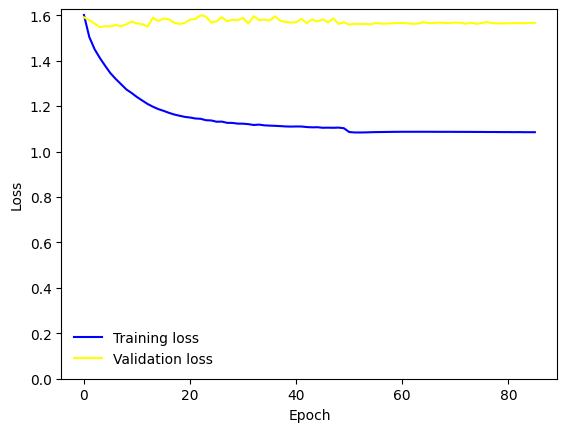

              precision    recall  f1-score   support

         SAD       0.58      0.44      0.50       381
         ANG       0.59      0.73      0.65       382
         NEU       0.57      0.49      0.53       326
         HAP       0.44      0.43      0.43       382
         FEA       0.40      0.44      0.42       381
         DIS       0.45      0.47      0.46       381

    accuracy                           0.50      2233
   macro avg       0.50      0.50      0.50      2233
weighted avg       0.50      0.50      0.50      2233



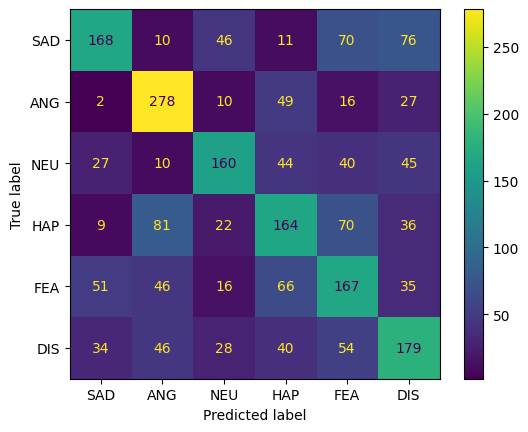

In [34]:
model = RezoNet([x_train[0][2].shape[0], x_train[0][2].shape[1]], hyperparameters = hyperparameters).to(device)
model.load_state_dict(torch.load("models/RezoNetbatch_size_16_epochs_250_learning_rate_1e-05_lr_decay_True_lr_decay_epoch_50_lr_decay_factor_0.1_weight_decay_0.01_current_epoch_5.pt"))
model.analyze(test_dataloader)

### <a id='toc1_9_4_'></a>[ExpoNet](#toc0_)

- The input to the network is expected to be 1D, representing the speech signal which will contains Zero Crossing Rate appended to Energy and appended to 1D flattened Mel Spectogram.

- The network architecture begins with a convolutional layer with 1 input channel, 512 output channels, a kernel size of 5, stride of 1 and same padding. This is followed by a ReLU activation function, batch normalization, and max pooling with a kernel size of 5, stride of 2 and same padding. The shape of the input is updated accordingly.

- The process is repeated for four additional convolutional layers with similar configurations but varying number of input and output channels. Each convolutional layer is followed by a ReLU activation, batch normalization, and max pooling layer, with the shape updated after each pooling operation.

- After the convolutional layers, the features are flattened using the nn.Flatten() module. Then, the flattened features are passed through two fully connected layers with 512 and 6 output units, respectively. The first fully connected layer is followed by a ReLU activation and batch normalization. Finally, the output is passed through a softmax function to obtain the predicted probabilities for each emotion class.
- The model can be modified to use Log Softmax instead of Softmax for faster computation and practicality reasons. However, using Softmax is not a problem in this case since that we are using a GPU to run the model.

#### <a id='toc1_9_4_1_'></a>[Model Architecture](#toc0_)

In [14]:
class ExpoNet(nn.Module):
    hyperparameters = None
    input_shape = None
    train_losses = []
    validation_losses = []
    current_epoch = 0
    def __init__(self, input_shape, hyperparameters):
        super(ExpoNet, self).__init__()
        self.hyperparameters = hyperparameters
        self.input_shape = input_shape
        self.current_epoch = 0

        # The input will be 1D and flattened
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.updateShape(5, 1, 2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding =2)
        self.updateShape(5, 2, 2)

        self.conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.updateShape(5, 1, 2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding =2)
        self.updateShape(5, 2, 2)

        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.updateShape(5, 1, 2)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding =2)
        self.updateShape(5, 2, 2)
        
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.updateShape(3, 1, 1)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding =2)
        self.updateShape(5, 2, 2)

        self.conv5 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.updateShape(3, 1, 1)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm1d(128)
        self.pool5 = nn.MaxPool1d(kernel_size=3, stride=2, padding =1)
        self.updateShape(3, 2, 1)


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * self.input_shape, 512)
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 6)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bn4(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bn5(x)
        x = self.pool5(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.bn6(x)
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)
        return x
    
    def trainEpochs(self, criterion, optimizer, train_loader, val_loader, num_epochs = 10, lr_decay = False, lr_decay_epoch = 5, lr_decay_factor = 0.1, save_each = None):

        for epoch in range(self.current_epoch, num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.train()
            for i, data in enumerate(train_loader):
                zcr, energy, melSpectogram, labels = data
                zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
                melSpectogram = melSpectogram.unsqueeze(1)
                melSpectogram = melSpectogram.view(min(self.hyperparameters['batch_size'], melSpectogram.size(0)), 1, -1)
                input = torch.cat((melSpectogram, zcr, energy), dim = 2)
                optimizer.zero_grad()
                outputs = self(input)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * melSpectogram.size(0)
            
            with torch.no_grad():
                self.eval()
                for i, data in enumerate(val_loader):
                    zcr, energy, melSpectogram, labels = data
                    zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
                    melSpectogram = melSpectogram.unsqueeze(1)
                    melSpectogram = melSpectogram.view(min(self.hyperparameters['batch_size'], melSpectogram.size(0)), 1, -1)
                    input = torch.cat((melSpectogram, zcr, energy), dim = 2)
                    outputs = self(input)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * melSpectogram.size(0)
                
            train_loss = train_loss / len(train_loader.dataset)
            val_loss = val_loss / len(val_loader.dataset)

            self.train_losses.append(train_loss)
            self.validation_losses.append(val_loss)

            print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(self.current_epoch + 1, train_loss, val_loss))

            if lr_decay and (self.current_epoch+1) % lr_decay_epoch == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= lr_decay_factor
            
            if save_each is not None and (self.current_epoch +1) % save_each == 0:
                self.saveModel()
            self.current_epoch += 1

    def predict(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

    def analyze(self, test_loader):
        self.eval()
        output = []
        label = []
        for i, data in enumerate(test_loader):
            zcr, energy, melSpectogram, labels = data
            zcr, energy, melSpectogram, labels = zcr.to(device), energy.to(device), melSpectogram.to(device), labels.to(device)
            melSpectogram = melSpectogram.unsqueeze(1)
            melSpectogram = melSpectogram.view(min(self.hyperparameters['batch_size'], melSpectogram.size(0)), 1, -1)
            input = torch.cat((melSpectogram, zcr, energy), dim = 2)
            output.append(self.predict(input))
            label.append(torch.argmax(labels, dim=1))
        output = torch.cat(output)
        label = torch.cat(label)
        self.plotHistory()
        print(classification_report(label.cpu(), output.cpu(), target_names=stringLabels))
        ConfusionMatrixDisplay(confusion_matrix(label.cpu(), output.cpu()), display_labels=stringLabels).plot()
        plt.show()

    def updateShape(self, kernel_size, stride, padding):
        self.input_shape = (self.input_shape + 2*padding - kernel_size) // stride + 1
    
    def plotHistory(self):
        plt.plot(self.train_losses, label = "Train")
        plt.plot(self.validation_losses, label = "Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    def saveModel(self):
        path = "models/ExpoNet"
        for key, value in self.hyperparameters.items():
            path += key + "_" + str(value) + "_"
        path += "current_epoch_" + str(self.current_epoch +1)
        path += ".pt"
        torch.save(self.state_dict(), path)

#### <a id='toc1_9_4_2_'></a>[Running the Model](#toc0_)

In [26]:
N_FFT = 512
HOP_SIZE = 160
N_MELS = 40
noise = True
time_shift = True
change_speed = True
pitch_shift = True
volume_scale = True


x_train, x_val, x_test, y_train, y_val, y_test = getFeatures(files=files, labels=labels, n_fft=N_FFT, hop_size = HOP_SIZE, n_mels= N_MELS, noise = noise, time_shift = time_shift, change_speed = change_speed, pitch_shift = pitch_shift, volume_scale = volume_scale)

train_dataset = AudioDataset(x_train, y_train)
val_dataset = AudioDataset(x_val, y_val)
test_dataset = AudioDataset(x_test, y_test)

Epoch: 1 	Training Loss: 1.587890 	Validation Loss: 1.549546
Epoch: 2 	Training Loss: 1.540172 	Validation Loss: 1.548896
Epoch: 3 	Training Loss: 1.504323 	Validation Loss: 1.523505
Epoch: 4 	Training Loss: 1.474653 	Validation Loss: 1.501832
Epoch: 5 	Training Loss: 1.428472 	Validation Loss: 1.524949
Epoch: 6 	Training Loss: 1.393369 	Validation Loss: 1.515782
Epoch: 7 	Training Loss: 1.352659 	Validation Loss: 1.563409
Epoch: 8 	Training Loss: 1.311599 	Validation Loss: 1.498509
Epoch: 9 	Training Loss: 1.267790 	Validation Loss: 1.498458
Epoch: 10 	Training Loss: 1.236343 	Validation Loss: 1.509043


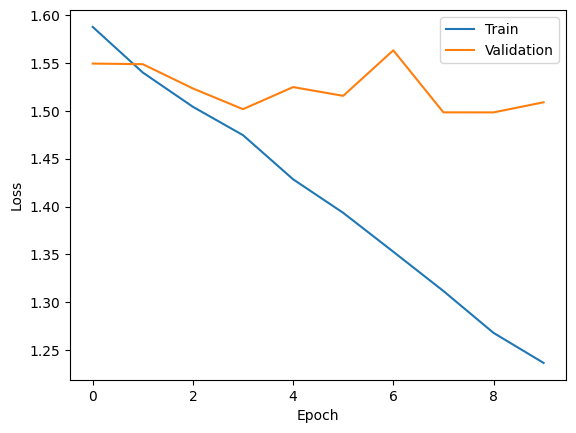

              precision    recall  f1-score   support

         SAD       0.60      0.41      0.49       381
         ANG       0.77      0.68      0.72       382
         NEU       0.48      0.81      0.60       326
         HAP       0.56      0.52      0.54       382
         FEA       0.46      0.53      0.49       381
         DIS       0.61      0.45      0.52       381

    accuracy                           0.56      2233
   macro avg       0.58      0.57      0.56      2233
weighted avg       0.58      0.56      0.56      2233



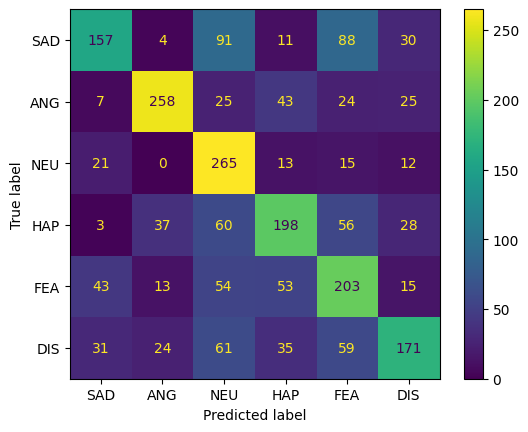

In [33]:
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 1e-5
LR_DECAY = False
LR_DECAY_EPOCH = 50
LR_DECAY_FACTOR = 0.1
WEIGHT_DECAY = 1e-3
SAVE_EACH = 1

hyperparameters = {"batch_size": BATCH_SIZE, "epochs": EPOCHS, "learning_rate": LEARNING_RATE, "lr_decay": LR_DECAY, "lr_decay_epoch": LR_DECAY_EPOCH, "lr_decay_factor": LR_DECAY_FACTOR, "weight_decay": WEIGHT_DECAY}

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = ExpoNet(x_train[0][0].shape[1] + x_train[0][1].shape[1] + (x_train[0][2].shape[0]*x_train[0][2].shape[1]), hyperparameters = hyperparameters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)
model.trainEpochs(criterion, optimizer, test_dataloader, val_dataloader, lr_decay=LR_DECAY, lr_decay_epoch=LR_DECAY_EPOCH, lr_decay_factor=LR_DECAY_FACTOR, save_each = SAVE_EACH)
model.analyze(test_dataloader)

- Now we will load the model at Epoch 8 since it gave the best results.

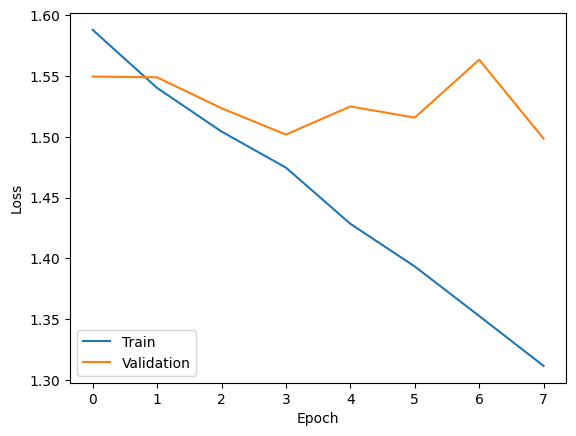

              precision    recall  f1-score   support

         SAD       0.51      0.69      0.59       381
         ANG       0.71      0.77      0.74       382
         NEU       0.56      0.70      0.62       326
         HAP       0.57      0.51      0.54       382
         FEA       0.56      0.39      0.46       381
         DIS       0.58      0.43      0.49       381

    accuracy                           0.58      2233
   macro avg       0.58      0.58      0.57      2233
weighted avg       0.58      0.58      0.57      2233



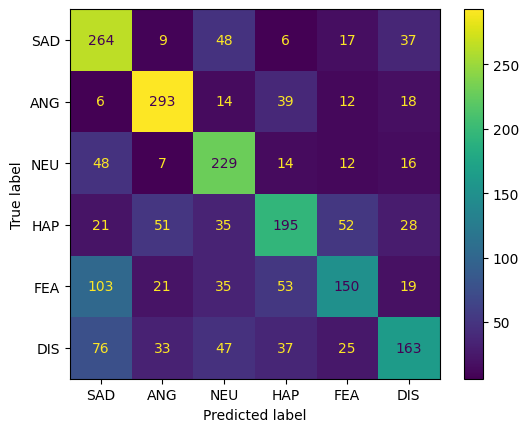

In [31]:
model = ExpoNet(x_train[0][0].shape[1] + x_train[0][1].shape[1] + (x_train[0][2].shape[0]*x_train[0][2].shape[1]), hyperparameters = hyperparameters).to(device)
model.load_state_dict(torch.load("models/ExpoNetbatch_size_8_epochs_5_learning_rate_1e-05_lr_decay_False_lr_decay_epoch_50_lr_decay_factor_0.1_weight_decay_0.001_current_epoch_8.pt"))
model.analyze(test_dataloader)

## <a id='toc1_10_'></a>[Final Thoughts](#toc0_)

- From all of the previous, it is clear that the best model is ExpoNet.
- The results can be further improved by using a bigger dataset but we will not be doing that in this project.
- The next step would be to build a two or three layer neural network which will ensemble the previous models and use the output of each model as an input to the neural network. This will help in improving the results even further. However, we don't have the enough time and computational power to do that in this project.